In [13]:
import optuna
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import synergy_dataset as sd
from IPython.display import display
import seaborn as sns

# Path to your SQLite3 database
db_path = ""

# Get all study summaries
study_summaries = optuna.get_all_study_summaries(storage=db_path)

for summary in study_summaries:
    print(f"- {summary.study_name}")

- ASReview2-rf_c-52-1
- ASReview2-log-52-1
- ASReview2-nb-52-1
- ASReview2-nb-52-2
- ASReview2-log-52-2
- ASReview2-log-52-3
- ASReview2-log-52-4
- ASReview2-log-52-5
- ASReview2-nb-52-3
- ASReview2-nb-52-4
- ASReview2-demo-svm-1
- ASReview2-demo-log-1
- ASReview2-demo-nb-1
- ASReview2-demo-rf-1
- ASReview2-full-nb-1
- ASReview2-demo-log-2
- ASReview2-demo-log-3
- ASReview2-demo-svm-2
- ASReview2-full-log-1
- ASReview2-demo-rf-2
- ASReview2-full-svm-1
- ASReview2-full-rf-1
- ASReview2-demo-labse-svm-1
- ASReview2-demo-bge-m3-svm-1
- ASReview2-full-labse-rf-1
- ASReview2-full-bge-m3-rf-1


In [14]:
study_name = "ASReview2-full-svm-1"
study = optuna.load_study(study_name=study_name, storage=db_path)
print(study.trials[0].params)

dataset_names = []
for i in sd.iter_datasets():
    if i.name != "Chou_2004":
        dataset_names.append(i.name)

dataset_names.sort()

{'ratio': 4.428735940026796, 'svm__C': 0.19473070682088334, 'tfidf__max_df': 0.8922065701517972, 'tfidf__min_df': 2, 'tfidf__max_ngram_range': 2}


In [15]:
# Prepare data for visualization
data = []

for trial in study.trials:
    if trial.intermediate_values:
        for dataset_id, value in enumerate(trial.intermediate_values.values()):
            params = trial.params  # Extract trial parameters
            # Record dataset_id, loss (intermediate value), and parameters
            data.append({
                "dataset_id": dataset_id,
                "loss": value,
                "ratio": params.get("ratio", None),
                "c": params.get("log__C", None)
            })

# Convert to pandas DataFrame
df = pd.DataFrame(data)

# Initialize variables to store the best trial per dataset
num_datasets = len(study.trials[0].intermediate_values)  # Assuming all trials have the same number of datasets
best_trials_per_dataset = [None] * num_datasets  # Store best trial numbers
best_losses_per_dataset = [float("inf")] * num_datasets  # Store best loss values
best_params_per_dataset = [None] * num_datasets  # Store best trial parameters

# Loop through all trials to find the best trial for each dataset
for trial in study.trials:
    if trial.intermediate_values:
        # Iterate through each dataset (position in the intermediate_values list)
        for dataset_id, loss in enumerate(trial.intermediate_values.values()):
            if loss < best_losses_per_dataset[dataset_id]:
                # Update the best trial info for this dataset
                best_losses_per_dataset[dataset_id] = loss
                best_trials_per_dataset[dataset_id] = trial.number
                best_params_per_dataset[dataset_id] = trial.params

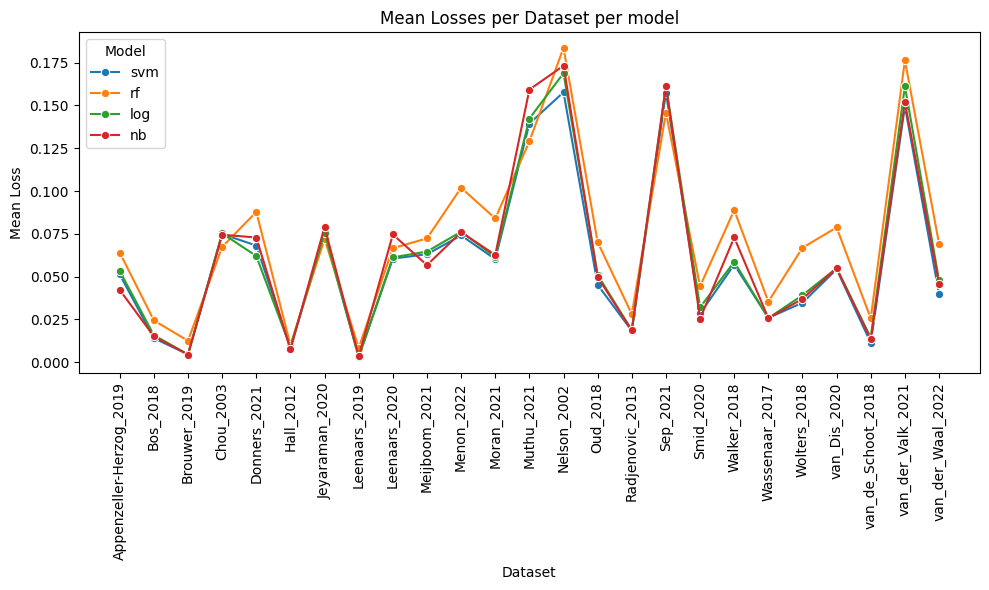

In [16]:
dfs = []
trial_ids = {}
for model in ["svm", "rf", "log", "nb"]:
    study = optuna.load_study(study_name=f"ASReview2-full-{model}-1", storage=db_path)
    df = pd.DataFrame(list(study.best_trial.intermediate_values.items()), columns=["Dataset", "Mean Loss"])
    df["Dataset"] = [dataset_names[i] for i in df["Dataset"]]
    df["Model"] = model
    dfs.append(df)
    trial_ids[model] = study.best_trial.number

# Combine all dataframes into one
combined_df = pd.concat(dfs, ignore_index=True)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_df, x="Dataset", y="Mean Loss", hue="Model", marker="o")
plt.title("Mean Losses per Dataset per model")
plt.xlabel("Dataset")
plt.xticks(rotation=90)
plt.ylabel("Mean Loss")
plt.tight_layout()
plt.show()

/var/folders/ls/wcyl7trn42jcdp0b2tp0mqqr0000gn/T/ipykernel_10427/255747895.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=diff_df, x="Dataset", y="Difference (NB - SVM)", palette="coolwarm")


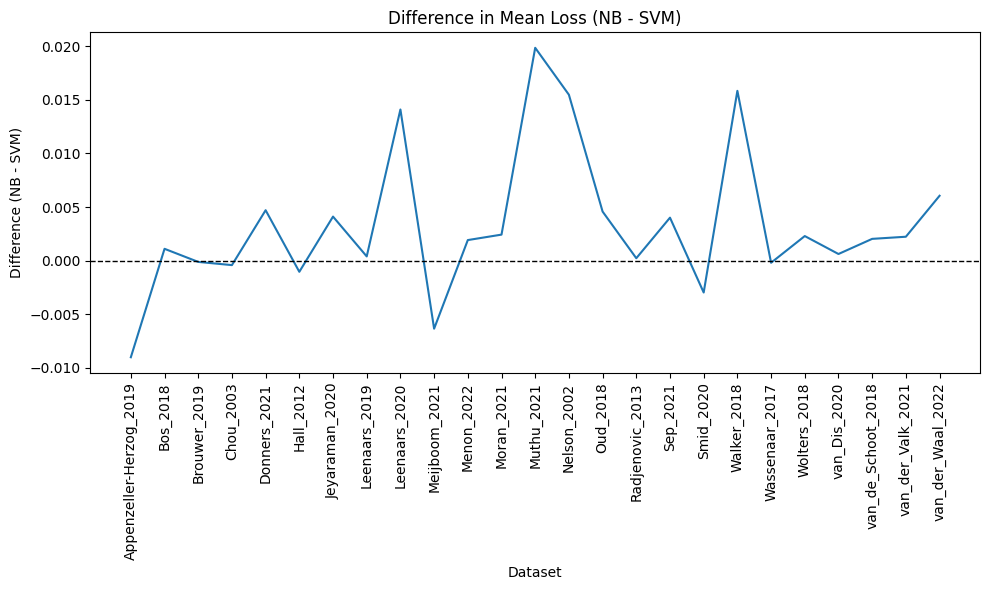

In [21]:
# Filter out data for NB and SVM models
nb_df = combined_df[combined_df["Model"] == "nb"].set_index("Dataset")
svm_df = combined_df[combined_df["Model"] == "svm"].set_index("Dataset")

# Calculate the difference: NB - SVM
diff_df = nb_df["Mean Loss"] - svm_df["Mean Loss"]
diff_df = diff_df.reset_index()
diff_df.columns = ["Dataset", "Difference (NB - SVM)"]

# Plot the differences
plt.figure(figsize=(10, 6))
sns.lineplot(data=diff_df, x="Dataset", y="Difference (NB - SVM)", palette="coolwarm")
plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.title("Difference in Mean Loss (NB - SVM)")
plt.xlabel("Dataset")
plt.xticks(rotation=90)
plt.ylabel("Difference (NB - SVM)")
plt.tight_layout()
plt.show()

In [17]:

# Create a pandas DataFrame
df = pd.DataFrame(best_params_per_dataset)

# Rename the rows to indicate the dataset number
df.index = [dataset_names[i] for i in range(len(best_params_per_dataset))]

display(df)

,ratio,svm__C,tfidf__max_df,tfidf__min_df,tfidf__max_ngram_range
Appenzeller-Herzog_2019,4.987551,0.025928,0.805144,2,2
Bos_2018,3.869205,0.010971,0.984581,1,2
Brouwer_2019,3.322439,0.076610,0.992343,2,2
Chou_2003,4.143143,0.010614,0.651951,10,2
Donners_2021,4.325232,0.908416,0.995601,7,3
Hall_2012,3.869205,0.010971,0.984581,1,2
Jeyaraman_2020,3.792946,0.191382,0.897441,1,3
Leenaars_2019,3.851675,0.310861,0.776236,1,2
Leenaars_2020,3.851675,0.310861,0.776236,1,2
Meijboom_2021,3.778240,0.185255,0.873117,1,3


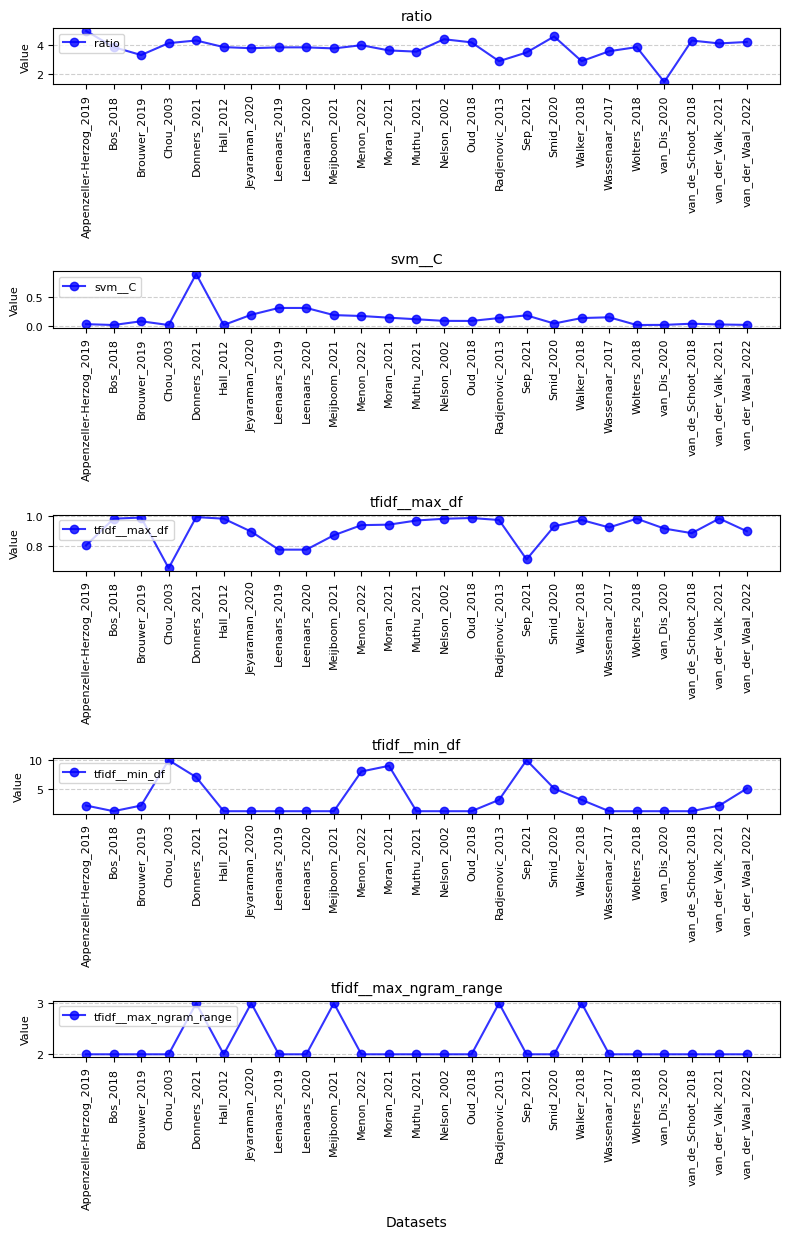

In [18]:
# Create a pandas DataFrame
df = pd.DataFrame(best_params_per_dataset)

# Plot each parameter separately
num_params = len(df.columns)
fig, axes = plt.subplots(num_params, 1, figsize=(8, num_params * 2.5), sharex=False)

for idx, param in enumerate(df.columns):
    ax = axes[idx]
    ax.plot(dataset_names, df[param], marker='o', linestyle='-', color='b', alpha=0.8, label=param)
    ax.set_title(param, fontsize=10)
    ax.set_ylabel("Value", fontsize=8)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.tick_params(axis="y", labelsize=8)
    ax.legend(fontsize=8, loc="upper left")
    
    # Set dataset names as x-tick labels for each plot
    ax.set_xticks(dataset_names)  # Setting positions explicitly
    ax.set_xticklabels(dataset_names, fontsize=8, rotation=90)  # Setting labels

# Add x-axis label only to the bottom subplot
axes[-1].set_xlabel("Datasets", fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Save or show the plot
#plt.savefig("parameter_comparison_lineplots_all_xticks_fixed.pdf", bbox_inches="tight", dpi=300)
plt.show()

/var/folders/ls/wcyl7trn42jcdp0b2tp0mqqr0000gn/T/ipykernel_10427/1288175922.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=dataset_names,


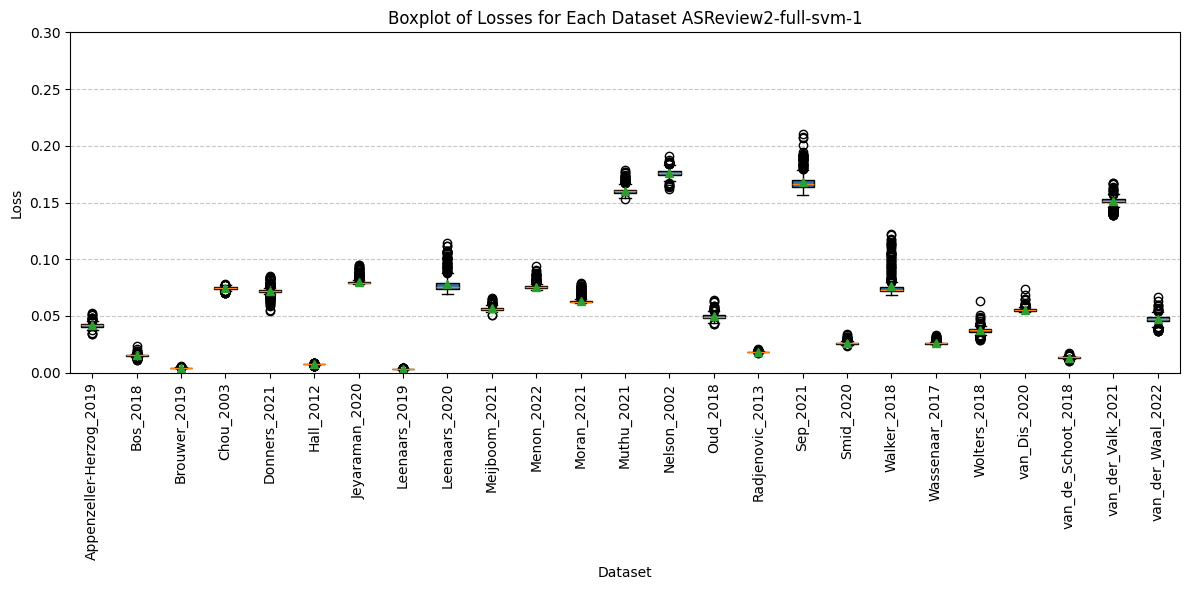

In [19]:
# Extract intermediate values grouped by dataset_id
dataset_intermediate_values = defaultdict(list)

for trial in study.trials:
    if trial.intermediate_values:
        # Distribute intermediate values by dataset_id (index in the list)
        for dataset_id, value in enumerate(trial.intermediate_values.values()):
            dataset_intermediate_values[dataset_id].append(value)

# Prepare data for boxplots
datasets = list(dataset_intermediate_values.keys())
boxplot_data = [dataset_intermediate_values[dataset_id] for dataset_id in datasets]

# Plot boxplots
plt.figure(figsize=(12, 6))
plt.boxplot(boxplot_data, labels=dataset_names, 
            showmeans=True, patch_artist=True)
plt.xlabel("Dataset")
plt.ylabel("Loss")
plt.title(f"Boxplot of Losses for Each Dataset {study_name}")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=90)  # Rotate dataset names for better readability
plt.tight_layout()
plt.ylim((0, 0.3))

# Show the plot
plt.tight_layout()
#plt.savefig(f"boxplot_per_dataset_{study_name}.pdf")
plt.show()
